In [4]:
# %load_ext lab_black


In [5]:
%reload_ext autoreload
%autoreload 1
import sklearn

sklearn.set_config(transform_output="pandas")
import category_encoders as ce
import numpy as np
import pandas as pd
import functions as myFunc
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import (
    f1_score,
    classification_report,
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna
from joblib import dump

In [6]:
pd.set_option("float_format", "{:.2f}".format)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 150)
set_config(display="diagram")


# Modeling of the sub grades using just most important features

In [7]:
accepted_loan_df1 = pd.read_csv(
    "accepted_2007_to_2018Q4.csv", header=0, skiprows=range(1, 1000000)
)


C:\Users\jonyt\AppData\Local\Temp\ipykernel_13496\1933929378.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  accepted_loan_df1 = pd.read_csv(


In [8]:
accepted_loan_df1.shape


(1260702, 151)

In [9]:
cleaned_df_accepted1 = (
    accepted_loan_df1.pipe(myFunc.copy_df)
    .pipe(myFunc.drop_duplicates)
    .pipe(
        myFunc.date_split_to_Y_M,
        [
            "issue_d",
        ],
    )
    .pipe(myFunc.replace_what_with_what, "term", " months", "")
    .pipe(myFunc.employment_Length_to_numeric, "emp_length")
    .pipe(
        myFunc.months_sin_cos,
        [
            "Month_issue_d",
        ],
    )
    .pipe(myFunc.log_feature, "loan_amnt")
    .pipe(myFunc.calc_risk, "fico_range_low", "fico_range_high")
    .pipe(myFunc.calc_risk, "sec_app_fico_range_low", "sec_app_fico_range_high")
    .pipe(myFunc.calc_risk, "last_fico_range_low", "last_fico_range_high")
    .pipe(
        myFunc.drop_columns,
        [
            "id",
            "member_id",
            "url",
            "purpose",
            "emp_title",
            "desc",
            "title",
            "zip_code",
            "addr_state",
            "policy_code",
            "Month_issue_d",
            "next_pymnt_d",
            "earliest_cr_line",
            "sec_app_earliest_cr_line",
            "last_credit_pull_d",
            "issue_d",
            "last_pymnt_d",
            "next_pymnt_d",
            "settlement_date",
            "debt_settlement_flag_date",
            "hardship_end_date",
            "payment_plan_start_date",
            "hardship_start_date",
            "fico_range_low",
            "fico_range_high",
            "sec_app_fico_range_low",
            "sec_app_fico_range_high",
            "last_fico_range_low",
            "last_fico_range_high",
            "revol_bal_joint",
            "tax_liens",
            "sec_app_num_rev_accts",
            "sec_app_mths_since_last_major_derog",
            "orig_projected_additional_accrued_interest",
            "num_tl_120dpd_2m",
            "hardship_amount",
            "settlement_term",
            "sec_app_chargeoff_within_12_mths",
            "collections_12_mths_ex_med",
            "hardship_payoff_balance_amount",
            "hardship_length",
            "delinq_amnt",
            "sec_app_open_act_il",
            "sec_app_inq_last_6mths",
            "chargeoff_within_12_mths",
            "settlement_amount",
            "hardship_dpd",
            "num_tl_30dpd",
            "acc_now_delinq",
            "settlement_percentage",
            "dti_joint",
            "sec_app_collections_12_mths_ex_med",
            "sec_app_open_acc",
            "sec_app_mort_acc",
            "sec_app_revol_util",
            "annual_inc_joint",
            "deferral_term",
            "hardship_last_payment_amount",
            "hardship_status",
            "hardship_type",
            "verification_status",
            "settlement_status",
            "hardship_loan_status",
            "hardship_flag",
            "pymnt_plan",
            "application_type",
            "debt_settlement_flag",
            "loan_status",
            "hardship_reason",
        ],
    )
    .pipe(myFunc.drop_rows_if_nan, "grade")
    .pipe(myFunc.drop_rows_if_nan, "sub_grade")
    .pipe(myFunc.drop_rows_if_nan, "int_rate")
    .pipe(
        myFunc.drop_columns,
        [
            "grade",
            "int_rate",
        ],
    )
)


In [10]:
cleaned_df_accepted1.shape


(1260681, 87)

Extraction of the second bach of data:

In [11]:
accepted_loan_df2 = pd.read_csv("accepted_2007_to_2018Q4.csv", nrows=1000000)


C:\Users\jonyt\AppData\Local\Temp\ipykernel_13496\9163249.py:1: DtypeWarning: Columns (0,19,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  accepted_loan_df2 = pd.read_csv("accepted_2007_to_2018Q4.csv", nrows=1000000)


In [12]:
accepted_loan_df2.head()


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.00,3600.00,3600.00,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.00,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.00,Aug-2003,675.00,679.00,1.00,30.00,NaN,7.00,0.00,2765.00,29.70,13.00,w,0.00,0.00,4421.72,4421.72,3600.00,821.72,0.00,0.00,0.00,Jan-2019,122.67,NaN,Mar-2019,564.00,560.00,0.00,30.00,1.00,Individual,NaN,NaN,NaN,0.00,722.00,144904.00,2.00,2.00,0.00,1.00,21.00,4981.00,36.00,3.00,3.00,722.00,34.00,9300.00,3.00,1.00,4.00,4.00,20701.00,1506.00,37.20,0.00,0.00,148.00,128.00,3.00,3.00,1.00,4.00,69.00,4.00,69.00,2.00,2.00,4.00,2.00,5.00,3.00,4.00,9.00,4.00,7.00,0.00,0.00,0.00,3.00,76.90,0.00,0.00,0.00,178050.00,7746.00,2400.00,13734.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.00,24700.00,24700.00,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.00,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.00,Dec-1999,715.00,719.00,4.00,6.00,NaN,22.00,0.00,21470.00,19.20,38.00,w,0.00,0.00,25679.66,25679.66,24700.00,979.66,0.00,0.00,0.00,Jun-2016,926.35,NaN,Mar-2019,699.00,695.00,0.00,NaN,1.00,Individual,NaN,NaN,NaN,0.00,0.00,204396.00,1.00,1.00,0.00,1.00,19.00,18005.00,73.00,2.00,3.00,6472.00,29.00,111800.00,0.00,0.00,6.00,4.00,9733.00,57830.00,27.10,0.00,0.00,113.00,192.00,2.00,2.00,4.00,2.00,NaN,0.00,6.00,0.00,5.00,

In [13]:
cleaned_df_accepted2 = (
    accepted_loan_df2.pipe(myFunc.copy_df)
    .pipe(myFunc.drop_duplicates)
    .pipe(
        myFunc.date_split_to_Y_M,
        ["issue_d"],
    )
    .pipe(myFunc.replace_what_with_what, "term", " months", "")
    .pipe(myFunc.employment_Length_to_numeric, "emp_length")
    .pipe(
        myFunc.months_sin_cos,
        [
            "Month_issue_d",
        ],
    )
    .pipe(myFunc.log_feature, "loan_amnt")
    .pipe(myFunc.calc_risk, "fico_range_low", "fico_range_high")
    .pipe(myFunc.calc_risk, "sec_app_fico_range_low", "sec_app_fico_range_high")
    .pipe(myFunc.calc_risk, "last_fico_range_low", "last_fico_range_high")
    .pipe(
        myFunc.drop_columns,
        [
            "id",
            "member_id",
            "url",
            "purpose",
            "emp_title",
            "desc",
            "title",
            "zip_code",
            "addr_state",
            "policy_code",
            "Month_issue_d",
            "next_pymnt_d",
            "earliest_cr_line",
            "sec_app_earliest_cr_line",
            "last_credit_pull_d",
            "issue_d",
            "last_pymnt_d",
            "next_pymnt_d",
            "settlement_date",
            "debt_settlement_flag_date",
            "hardship_end_date",
            "payment_plan_start_date",
            "hardship_start_date",
            "fico_range_low",
            "fico_range_high",
            "sec_app_fico_range_low",
            "sec_app_fico_range_high",
            "last_fico_range_low",
            "last_fico_range_high",
            "revol_bal_joint",
            "tax_liens",
            "sec_app_num_rev_accts",
            "sec_app_mths_since_last_major_derog",
            "orig_projected_additional_accrued_interest",
            "num_tl_120dpd_2m",
            "hardship_amount",
            "settlement_term",
            "sec_app_chargeoff_within_12_mths",
            "collections_12_mths_ex_med",
            "hardship_payoff_balance_amount",
            "hardship_length",
            "delinq_amnt",
            "sec_app_open_act_il",
            "sec_app_inq_last_6mths",
            "chargeoff_within_12_mths",
            "settlement_amount",
            "hardship_dpd",
            "num_tl_30dpd",
            "acc_now_delinq",
            "settlement_percentage",
            "dti_joint",
            "sec_app_collections_12_mths_ex_med",
            "sec_app_open_acc",
            "sec_app_mort_acc",
            "sec_app_revol_util",
            "annual_inc_joint",
            "deferral_term",
            "hardship_last_payment_amount",
            "hardship_status",
            "hardship_type",
            "verification_status",
            "settlement_status",
            "hardship_loan_status",
            "hardship_flag",
            "pymnt_plan",
            "application_type",
            "debt_settlement_flag",
            "loan_status",
            "hardship_reason",
        ],
    )
    .pipe(myFunc.drop_rows_if_nan, "grade")
    .pipe(myFunc.drop_rows_if_nan, "sub_grade")
    .pipe(myFunc.drop_rows_if_nan, "int_rate")
    .pipe(
        myFunc.drop_columns,
        [
            "grade",
            "int_rate",
        ],
    )
)


Let's concatinate two parts of data.

In [14]:
cleaned_df_accepted = pd.concat([cleaned_df_accepted1, cleaned_df_accepted2])


In [15]:
lst = [cleaned_df_accepted2, cleaned_df_accepted1]
del [cleaned_df_accepted2, cleaned_df_accepted1]
del lst


In [16]:
cleaned_df_accepted.shape


(2260669, 87)

Just to be sure, let's check for duplibates and drop if any.

In [17]:
cleaned_df_accepted = cleaned_df_accepted.drop_duplicates()
cleaned_df_accepted.shape


(2260668, 87)

First, we need to encode our target.

## Encoding target variable

In [18]:
cleaned_df_accepted["sub_grade"].value_counts()


sub_grade
C1    145903
B5    140288
B4    139793
B3    131514
C2    131116
C3    129193
C4    127115
B2    126621
B1    125341
C5    116726
A5    107617
A4     95874
A1     86790
D1     81787
A3     73184
D2     72899
A2     69562
D3     64819
D4     56896
D5     48023
E1     33573
E2     29924
E3     26708
E4     22763
E5     22671
F1     13413
F2      9305
F3      7791
F4      6124
F5      5167
G1      4106
G2      2688
G3      2094
G4      1712
G5      1568
Name: count, dtype: int64

In [19]:
cleaned_df_accepted = cleaned_df_accepted.replace(
    {
        "A1": 0,
        "A2": 1,
        "A3": 2,
        "A4": 3,
        "A5": 4,
        "B1": 5,
        "B2": 6,
        "B3": 7,
        "B4": 8,
        "B5": 9,
        "C1": 10,
        "C2": 11,
        "C3": 12,
        "C4": 13,
        "C5": 14,
        "D1": 15,
        "D2": 16,
        "D3": 17,
        "D4": 18,
        "D5": 19,
        "E1": 20,
        "E2": 21,
        "E3": 22,
        "E4": 23,
        "E5": 24,
        "F1": 25,
        "F2": 26,
        "F3": 27,
        "F4": 28,
        "F5": 29,
        "G1": 30,
        "G2": 31,
        "G3": 32,
        "G4": 33,
        "G5": 34,
    }
)


## Spliting into train, test and validation sets

Let's split data into training and testing sets.

In [20]:
df_train, df_test_val = train_test_split(
    cleaned_df_accepted,
    test_size=0.2,
    random_state=2,
    stratify=cleaned_df_accepted["sub_grade"],
)
df_test, df_val = train_test_split(
    df_test_val,
    test_size=0.5,
    random_state=3,
    stratify=df_test_val["sub_grade"],
)


In [21]:
df_train.sub_grade.value_counts()


sub_grade
10    116722
9     112230
8     111834
7     105211
11    104893
12    103354
13    101692
6     101297
5     100273
14     93381
4      86094
3      76699
0      69432
15     65430
2      58547
16     58319
1      55650
17     51855
18     45517
19     38418
20     26858
21     23939
22     21366
23     18210
24     18137
25     10730
26      7444
27      6233
28      4899
29      4134
30      3285
31      2151
32      1675
33      1370
34      1255
Name: count, dtype: int64

We may see, that our classes are imbalansed in train set, so we will need to balance it according to the smallest class amount.

In [22]:
grouped_classes1 = df_train.groupby("sub_grade", group_keys=False)

df_train = pd.DataFrame(
    grouped_classes1.apply(lambda x: x.sample(grouped_classes1.size().min()))
).reset_index(drop=True)


Let's check if our target is balanced.

In [23]:
df_train.sub_grade.value_counts()


sub_grade
0     1255
26    1255
20    1255
21    1255
22    1255
23    1255
24    1255
25    1255
27    1255
18    1255
28    1255
29    1255
30    1255
31    1255
32    1255
33    1255
19    1255
17    1255
1     1255
8     1255
2     1255
3     1255
4     1255
5     1255
6     1255
7     1255
9     1255
16    1255
10    1255
11    1255
12    1255
13    1255
14    1255
15    1255
34    1255
Name: count, dtype: int64

In [24]:
df_test.sub_grade.value_counts()


sub_grade
10    14590
9     14029
8     13980
7     13151
11    13111
12    12919
13    12711
6     12662
5     12534
14    11672
4     10762
3      9588
0      8679
15     8178
2      7318
16     7290
1      6956
17     6482
18     5689
19     4803
20     3358
21     2993
22     2671
23     2277
24     2267
25     1342
26      931
27      779
28      612
29      516
30      411
31      269
32      210
33      171
34      156
Name: count, dtype: int64

In [25]:
df_val.sub_grade.value_counts()


sub_grade
10    14591
9     14029
8     13979
7     13152
11    13112
12    12920
13    12712
6     12662
5     12534
14    11673
4     10761
3      9587
0      8679
15     8179
2      7319
16     7290
1      6956
17     6482
18     5690
19     4802
20     3357
21     2992
22     2671
23     2276
24     2267
25     1341
26      930
27      779
28      613
29      517
30      410
31      268
32      209
33      171
34      157
Name: count, dtype: int64

Now we can get final data sets, wich we will be using for modeling part.

In [26]:
X_train = df_train.drop(["sub_grade"], axis=1)
y_train = df_train["sub_grade"]
X_test = df_test.drop(["sub_grade"], axis=1)
y_test = df_test["sub_grade"]
X_val = df_val.drop(["sub_grade"], axis=1)
y_val = df_val["sub_grade"]


In [27]:
X_train.shape, X_test.shape, X_val.shape


((43925, 86), (226067, 86), (226067, 86))

In [28]:
y_train.shape, y_test.shape, y_val.shape


((43925,), (226067,), (226067,))

Realease RAM mermory:

In [29]:
lst = [df_train, df_test_val, cleaned_df_accepted]
del [df_train, df_test_val, cleaned_df_accepted]
del lst


## Columns selection

In [30]:
numeric_cols2 = X_train.select_dtypes(include=np.number).columns.to_list()


In [31]:
dummy_cols = list(set(X_train.columns) - set(numeric_cols2))


In [32]:
categorical_transformer = Pipeline(
    [
        (
            "rare_categorical_replace",
            ColumnTransformer(
                [
                    (
                        "rare_cat_replace",
                        FunctionTransformer(
                            myFunc.replace_rare_categorical_values,
                            validate=False,
                        ),
                        dummy_cols,
                    ),
                ]
            ),
        ),
        (
            "imputer",
            SimpleImputer(
                missing_values=np.nan,
                strategy="constant",
                fill_value="-9999",
            ),
        ),
        ("onehot_encoder", ce.OneHotEncoder()),
    ]
)


In [33]:
numeric_transformer = Pipeline(
    steps=[
        (
            "imputer",
            SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=-9999),
        )
    ]
)


In [34]:
preprocessor1 = ColumnTransformer(
    transformers=[
        ("numeric_transformer", numeric_transformer, numeric_cols2),
        ("onehot", categorical_transformer, dummy_cols),
    ],
    remainder="passthrough",
)


In [35]:
final_pipeline = Pipeline(
    steps=[
        ("preprocessor1", preprocessor1),
    ]
)


### Base models

In [29]:
balanced_accuracy = []
accuracy = []
recall = []
precision = []
f1_scores = []
fit_time = []
kfold = StratifiedKFold(n_splits=3)
classifiers = [
    "XGB classifier",
    "LGBM classifier",
    "AdaBoostClassifier",
    "RandomForest",
]


models = [
    XGBClassifier(objective="multi:softmax"),
    LGBMClassifier(objective="multiclass"),
    AdaBoostClassifier(n_estimators=50, random_state=0),
    RandomForestClassifier(n_estimators=50, random_state=0),
]


for model in models:
    pipeline = Pipeline(
        steps=[
            ("preprocessor1", preprocessor1),
            ("classifier", model),
        ]
    )
    result = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=kfold,
        scoring=(
            "balanced_accuracy",
            "accuracy",
            "f1_macro",
            "recall_macro",
            "precision_macro",
        ),
    )
    fit_time.append(result["fit_time"].mean())
    balanced_accuracy.append(result["test_balanced_accuracy"].mean())
    accuracy.append(result["test_accuracy"].mean())
    recall.append(result["test_recall_macro"].mean())
    precision.append(result["test_precision_macro"].mean())
    f1_scores.append(result["test_f1_macro"].mean())

base_models = pd.DataFrame(
    {
        "Balanced accuracy": balanced_accuracy,
        "Accuracy": accuracy,
        "Recall": recall,
        "Precision": precision,
        "f1": f1_scores,
        "Fit_time": fit_time,
    },
    index=classifiers,
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11159
[LightGBM] [Info] Number of data points in the train set: 29283, number of used features: 93
[LightGBM] [Info] Start training from score -3.556134
[LightGBM] [Info] Start training from score -3.554938
[LightGBM] [Info] Start training from score -3.554938
[LightGBM] [Info] Start training from score -3.556134
[LightGBM] [Info] Start training from score -3.554938
[LightGBM] [Info] Start training from score -3.554938
[LightGBM] [Info] Start training from score -3.556134
[LightGBM] [Info] Start training from score -3.554938
[LightGBM] [Info] Start training from score -3.554938
[LightGBM] [Info] Start training from score -3.556134
[LightGBM] [Info] Start training from score -3.554938
[LightGBM] [Info] Start training from score -3.554938
[LightGBM] [Info] Start training from score -3.556134
[LightGB

In [30]:
base_models


,Balanced accuracy,Accuracy,Recall,Precision,f1,Fit_time
XGB classifier,0.18,0.18,0.18,0.18,0.18,41.73
LGBM classifier,0.18,0.18,0.18,0.17,0.17,29.66
AdaBoostClassifier,0.09,0.09,0.09,0.09,0.08,13.96
RandomForest,0.11,0.11,0.11,0.10,0.11,23.86


Best performing models are XGB classifier and LGBM classifier with average f1 score 0.18 for all sub groups.

## Random forest hyperparameters tuning

In [31]:
def objective_rf(trial):
    """Suggests values for hyperparameters, fits model and makes predictions and calculates f1 score"""

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 200, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 32),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
    }

    pipeline = Pipeline(
        steps=[
            ("preprocessor1", preprocessor1),
            (
                "classifier",
                RandomForestClassifier(**params),
            ),
        ]
    )
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_val)

    metric = f1_score(y_val, y_pred, average="macro")
    return metric


In [32]:
study_rf = optuna.create_study(direction="maximize")
func_rf = lambda trial: objective_rf(trial)
study_rf.optimize(func_rf, n_trials=30)


[I 2023-10-20 10:29:04,515] A new study created in memory with name: no-name-9c53ad7b-e68e-49e8-98e1-6c6fa27d3f93
[I 2023-10-20 10:29:10,397] Trial 0 finished with value: 0.0747736355319356 and parameters: {'n_estimators': 12, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.0747736355319356.
[I 2023-10-20 10:29:28,064] Trial 1 finished with value: 0.0671518692805646 and parameters: {'n_estimators': 65, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.0747736355319356.
[I 2023-10-20 10:29:37,876] Trial 2 finished with value: 0.08233242413242362 and parameters: {'n_estimators': 13, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.08233242413242362.
[I 2023-10-20 10:29:43,641] Trial 3 finished with value: 0.039861277936416924 and parameters: {'n_estimators': 25, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 2 with value: 0

In [33]:
print("Number of finished trials: {}".format(len(study_rf.trials)))
print("Best trial:")
trial_rf_best = study_rf.best_trial

print("  Value: {}".format(trial_rf_best.value))
print("  Params: ")

for key, value in trial_rf_best.params.items():
    print("    {}: {}".format(key, value))


Number of finished trials: 30
Best trial:
  Value: 0.1125733698670504
  Params: 
    n_estimators: 200
    max_depth: 28
    min_samples_split: 3
    min_samples_leaf: 3


In [34]:
params_best_rf = trial_rf_best.params

pipeline_rf = Pipeline(
    steps=[
        ("preprocessor1", preprocessor1),
        (
            "classifier",
            RandomForestClassifier(**params_best_rf),
        ),
    ]
)
model_tuned_rf = pipeline_rf.fit(X_train, y_train)
y_pred_vv = model_tuned_rf.predict(X_val)
print("\nClassification Report for Random Forest")
print(classification_report(y_val, y_pred_vv))



Classification Report for Random Forest
              precision    recall  f1-score   support

           0       0.35      0.63      0.45      8679
           1       0.15      0.26      0.19      6956
           2       0.12      0.20      0.15      7319
           3       0.14      0.18      0.16      9587
           4       0.16      0.18      0.17     10761
           5       0.17      0.17      0.17     12534
           6       0.14      0.13      0.13     12662
           7       0.15      0.13      0.14     13152
           8       0.16      0.12      0.13     13979
           9       0.16      0.17      0.16     14029
          10       0.17      0.13      0.14     14591
          11       0.13      0.08      0.10     13112
          12       0.16      0.11      0.13     12920
          13       0.17      0.11      0.13     12712
          14       0.15      0.11      0.13     11673
          15       0.11      0.08      0.10      8179
          16       0.11      0.08      0

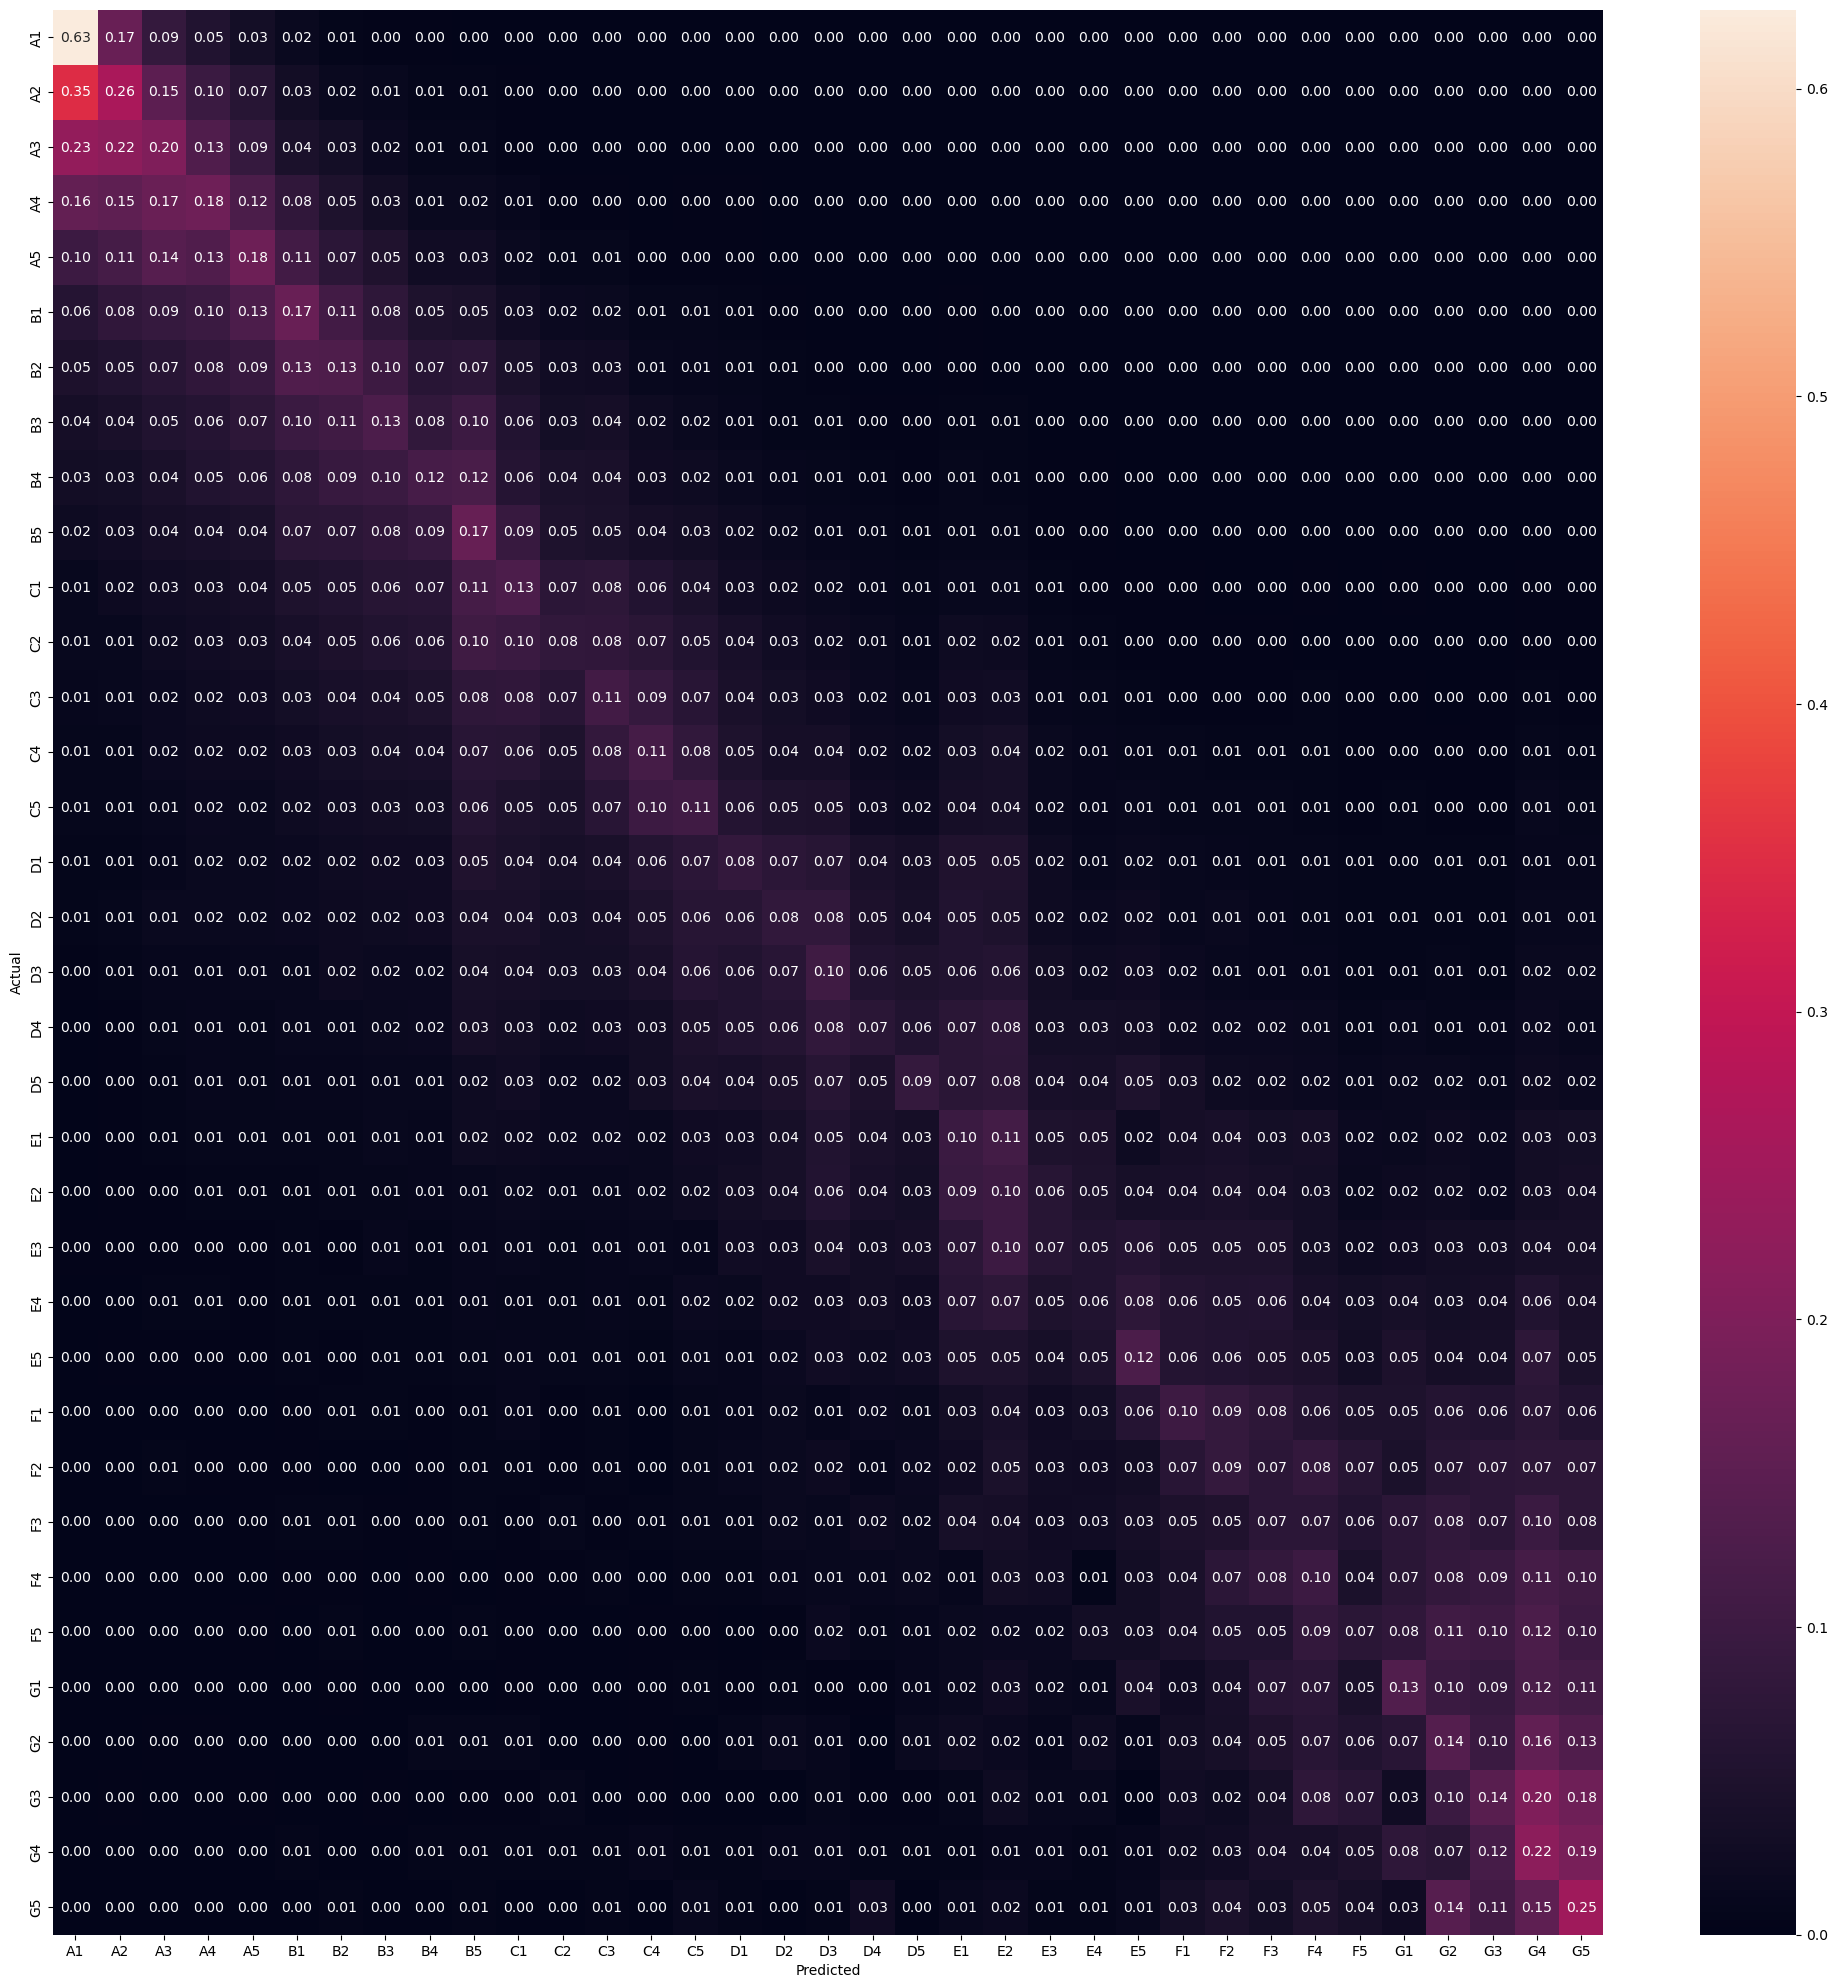

In [35]:
myFunc.big_confusion_matrix_normalized(
    y_val,
    y_pred_vv,
    [
        "A1",
        "A2",
        "A3",
        "A4",
        "A5",
        "B1",
        "B2",
        "B3",
        "B4",
        "B5",
        "C1",
        "C2",
        "C3",
        "C4",
        "C5",
        "D1",
        "D2",
        "D3",
        "D4",
        "D5",
        "E1",
        "E2",
        "E3",
        "E4",
        "E5",
        "F1",
        "F2",
        "F3",
        "F4",
        "F5",
        "G1",
        "G2",
        "G3",
        "G4",
        "G5",
    ],
)


## LGBM hyperparameters tuning

In [36]:
def objective_lgbm(trial):
    """Suggests values for hyperparameters, fits model and makes predictions and calculates f1 score"""

    params = {
        "num_boost_round": trial.suggest_int("num_boost_round", 0, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "verbose": -1,
    }

    pipeline = Pipeline(
        steps=[
            ("preprocessor1", preprocessor1),
            (
                "classifier",
                LGBMClassifier(**params, objective="multiclass", force_col_wise=True),
            ),
        ]
    )
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_val)

    metric = f1_score(y_val, y_pred, average="macro")
    return metric


In [37]:
study_lgbm = optuna.create_study(direction="maximize")
func_lgbm = lambda trial: objective_lgbm(trial)
study_lgbm.optimize(func_lgbm, n_trials=30)


[I 2023-10-27 01:05:42,695] A new study created in memory with name: no-name-722cf254-7611-4861-a5d6-f609d7d77c81


c:\Users\jonyt\anaconda3\envs\conda_ds_39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-10-27 01:07:51,873] Trial 0 finished with value: 0.04656687629239201 and parameters: {'num_boost_round': 726, 'learning_rate': 0.027642815058712043, 'num_leaves': 600, 'max_depth': 4, 'min_data_in_leaf': 3700, 'lambda_l1': 35, 'lambda_l2': 35, 'min_gain_to_split': 11.601187370401451}. Best is trial 0 with value: 0.04656687629239201.
c:\Users\jonyt\anaconda3\envs\conda_ds_39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-10-27 01:08:36,407] Trial 1 finished with value: 0.04577992827817179 and parameters: {'num_boost_round': 367, 'learning_rate': 0.28799615129114714, 'num_leaves': 126

In [38]:
print("Number of finished trials: {}".format(len(study_lgbm.trials)))
print("Best trial:")
trial_lgbm_best = study_lgbm.best_trial

print("  Value: {}".format(trial_lgbm_best.value))
print("  Params: ")

for key, value in trial_lgbm_best.params.items():
    print("    {}: {}".format(key, value))


Number of finished trials: 30
Best trial:
  Value: 0.1314045060828488
  Params: 
    num_boost_round: 448
    learning_rate: 0.22833443507087076
    num_leaves: 2420
    max_depth: 7
    min_data_in_leaf: 8400
    lambda_l1: 5
    lambda_l2: 85
    min_gain_to_split: 0.24437733961774177


Now, let's refit LGBMClassifier using the best paraneters.

In [39]:
params_best = trial_lgbm_best.params

pipeline_tuned_LGBM = Pipeline(
    steps=[
        ("preprocessor1", preprocessor1),
        (
            "classifier",
            LGBMClassifier(
                **params_best, objective="multiclass", force_col_wise=True, verbose=-1
            ),
        ),
    ]
)
model_tuned_LGBM = pipeline_tuned_LGBM.fit(X_train, y_train)
y_pred_val = model_tuned_LGBM.predict(X_val)

c:\Users\jonyt\anaconda3\envs\conda_ds_39\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [40]:
print("\nClassification Report for LightGBM")
print(classification_report(y_val, y_pred_val))



Classification Report for LightGBM
              precision    recall  f1-score   support

           0       0.54      0.66      0.59      8679
           1       0.28      0.38      0.32      6956
           2       0.24      0.34      0.28      7319
           3       0.27      0.31      0.29      9587
           4       0.29      0.32      0.30     10761
           5       0.24      0.23      0.23     12534
           6       0.22      0.22      0.22     12662
           7       0.19      0.19      0.19     13152
           8       0.22      0.19      0.20     13979
           9       0.25      0.23      0.24     14029
          10       0.25      0.19      0.22     14591
          11       0.18      0.16      0.17     13112
          12       0.18      0.13      0.15     12920
          13       0.18      0.14      0.15     12712
          14       0.17      0.12      0.14     11673
          15       0.12      0.09      0.11      8179
          16       0.11      0.10      0.11  

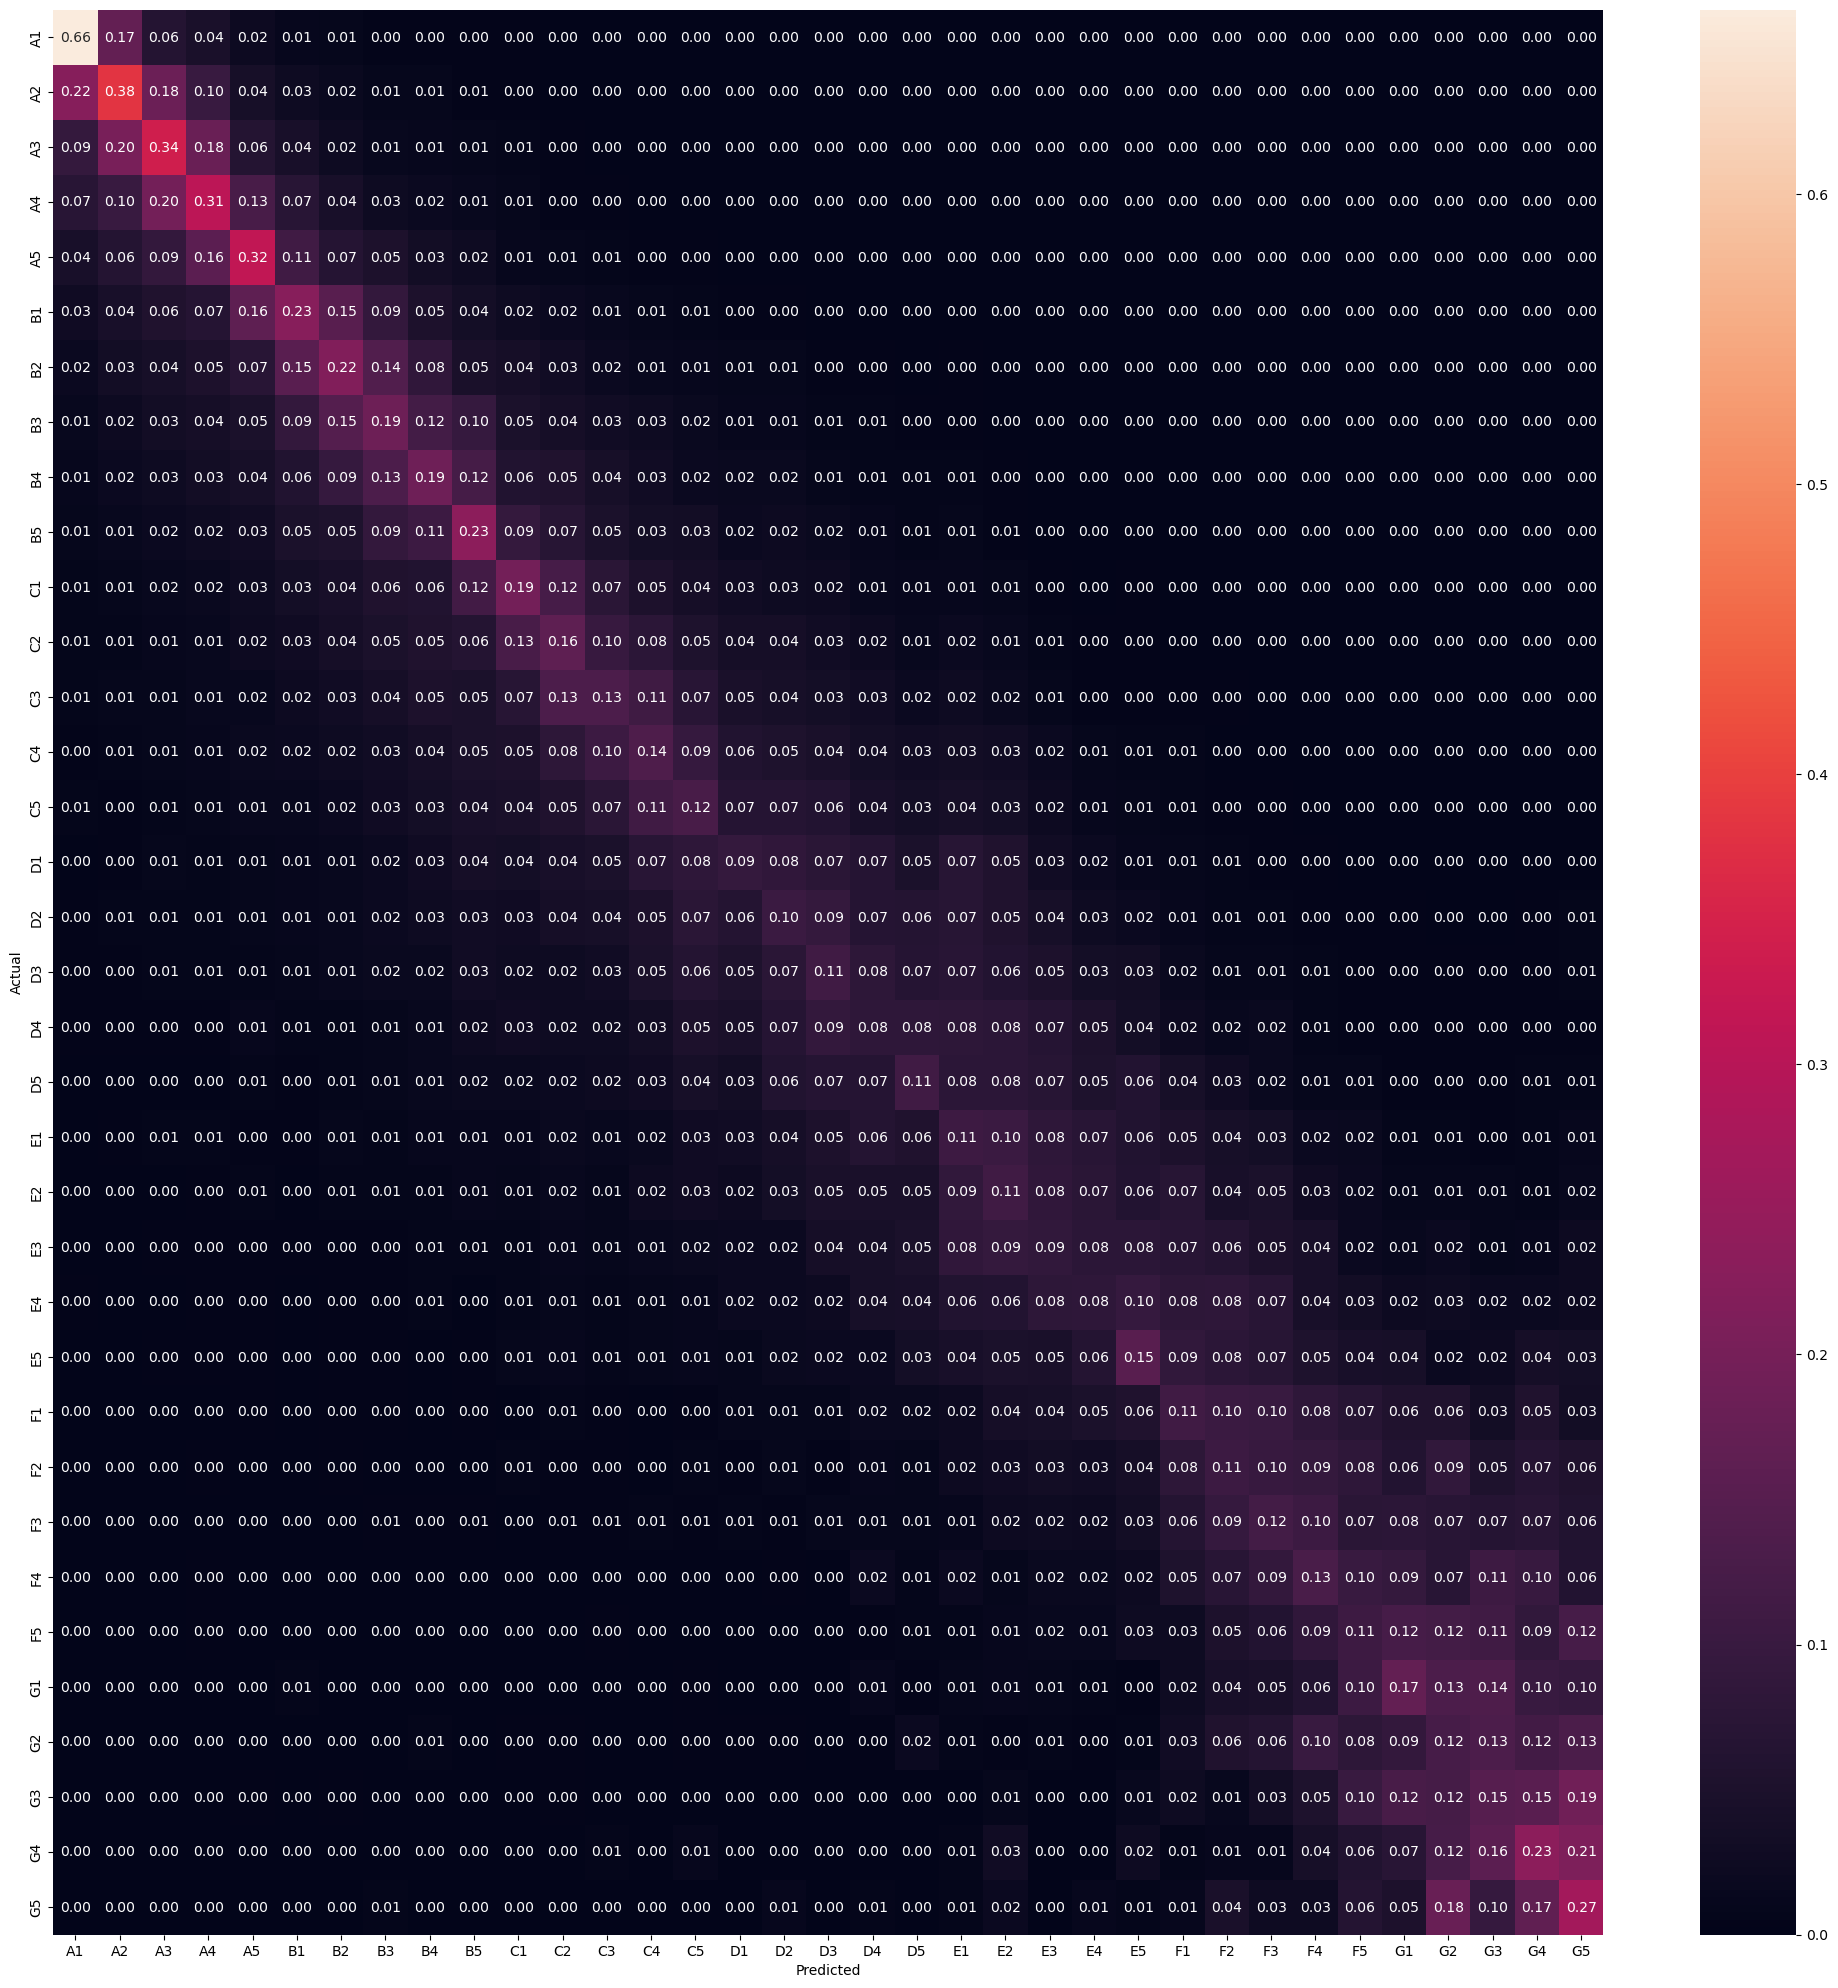

In [41]:
myFunc.big_confusion_matrix_normalized(
    y_val,
    y_pred_val,
    [
        "A1",
        "A2",
        "A3",
        "A4",
        "A5",
        "B1",
        "B2",
        "B3",
        "B4",
        "B5",
        "C1",
        "C2",
        "C3",
        "C4",
        "C5",
        "D1",
        "D2",
        "D3",
        "D4",
        "D5",
        "E1",
        "E2",
        "E3",
        "E4",
        "E5",
        "F1",
        "F2",
        "F3",
        "F4",
        "F5",
        "G1",
        "G2",
        "G3",
        "G4",
        "G5",
    ],
)


## XGB hyperparameters tuning

In [42]:
def objective_xgb(trial):
    """Define the objective function"""

    params = {
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
        "subsample": trial.suggest_loguniform("subsample", 0.01, 1.0),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.01, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 1.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 1.0),
        "eval_metric": "mlogloss",
        "use_label_encoder": False,
    }

    pipeline = Pipeline(
        steps=[
            ("preprocessor1", preprocessor1),
            (
                "classifier",
                XGBClassifier(**params, objective="multi:softmax"),
            ),
        ]
    )
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_val)

    metric = f1_score(y_val, y_pred, average="macro")
    return metric


In [43]:
study_xgb = optuna.create_study(direction="maximize")
func_xgb = lambda trial: objective_xgb(trial)
study_xgb.optimize(func_xgb, n_trials=30)


[I 2023-10-20 12:22:16,128] A new study created in memory with name: no-name-54daae71-7997-4546-b708-e97f2eb762b4


[I 2023-10-20 12:23:24,419] Trial 0 finished with value: 0.08155000189233036 and parameters: {'max_depth': 8, 'learning_rate': 0.11450491985827078, 'n_estimators': 111, 'min_child_weight': 4, 'gamma': 4.50809747190665e-07, 'subsample': 0.0613992806369492, 'colsample_bytree': 0.3355299427223845, 'reg_alpha': 3.431940978640824e-08, 'reg_lambda': 4.491160572157849e-05}. Best is trial 0 with value: 0.08155000189233036.
[I 2023-10-20 12:23:43,469] Trial 1 finished with value: 0.049325839121552834 and parameters: {'max_depth': 2, 'learning_rate': 0.05450616929822758, 'n_estimators': 65, 'min_child_weight': 10, 'gamma': 0.004770126694921429, 'subsample': 0.029817619634652428, 'colsample_bytree': 0.12449770930236634, 'reg_alpha': 0.00017907817373561983, 'reg_lambda': 2.1007370407766985e-06}. Best is trial 0 with value: 0.08155000189233036.
[I 2023-10-20 12:25:29,668] Trial 2 finished with value: 0.07561520991792589 and parameters: {'max_depth': 4, 'learning_rate': 0.45984092521327696, 'n_estim

In [44]:
print("Number of finished trials: {}".format(len(study_xgb.trials)))
print("Best trial:")
trial_xgb_best = study_xgb.best_trial

print("  Value: {}".format(trial_xgb_best.value))
print("  Params: ")

for key, value in trial_xgb_best.params.items():
    print("    {}: {}".format(key, value))


Number of finished trials: 30
Best trial:
  Value: 0.20995659627434246
  Params: 
    max_depth: 7
    learning_rate: 0.0703890095115369
    n_estimators: 490
    min_child_weight: 4
    gamma: 7.236692299505513e-08
    subsample: 0.9136706370353723
    colsample_bytree: 0.3553521965819452
    reg_alpha: 0.18847638375559891
    reg_lambda: 1.0830268712305553e-07


In [45]:
params_best_xgb = trial_xgb_best.params

pipeline_xgb = Pipeline(
    steps=[
        ("preprocessor1", preprocessor1),
        (
            "classifier",
            XGBClassifier(**params_best_xgb),
        ),
    ]
)
model_tuned_xgb = pipeline_xgb.fit(X_train, y_train)
y_pred_v = model_tuned_xgb.predict(X_val)
print("\nClassification Report for XGB Classifier")
print(classification_report(y_val, y_pred_v))



Classification Report for XGB Classifier
              precision    recall  f1-score   support

           0       0.66      0.70      0.68      8679
           1       0.34      0.43      0.38      6956
           2       0.27      0.35      0.30      7319
           3       0.32      0.33      0.33      9587
           4       0.35      0.37      0.36     10761
           5       0.30      0.27      0.29     12534
           6       0.26      0.27      0.27     12662
           7       0.25      0.22      0.23     13152
           8       0.28      0.25      0.26     13979
           9       0.30      0.28      0.29     14029
          10       0.30      0.28      0.29     14591
          11       0.23      0.23      0.23     13112
          12       0.26      0.24      0.25     12920
          13       0.25      0.23      0.24     12712
          14       0.28      0.24      0.26     11673
          15       0.20      0.22      0.21      8179
          16       0.18      0.16      

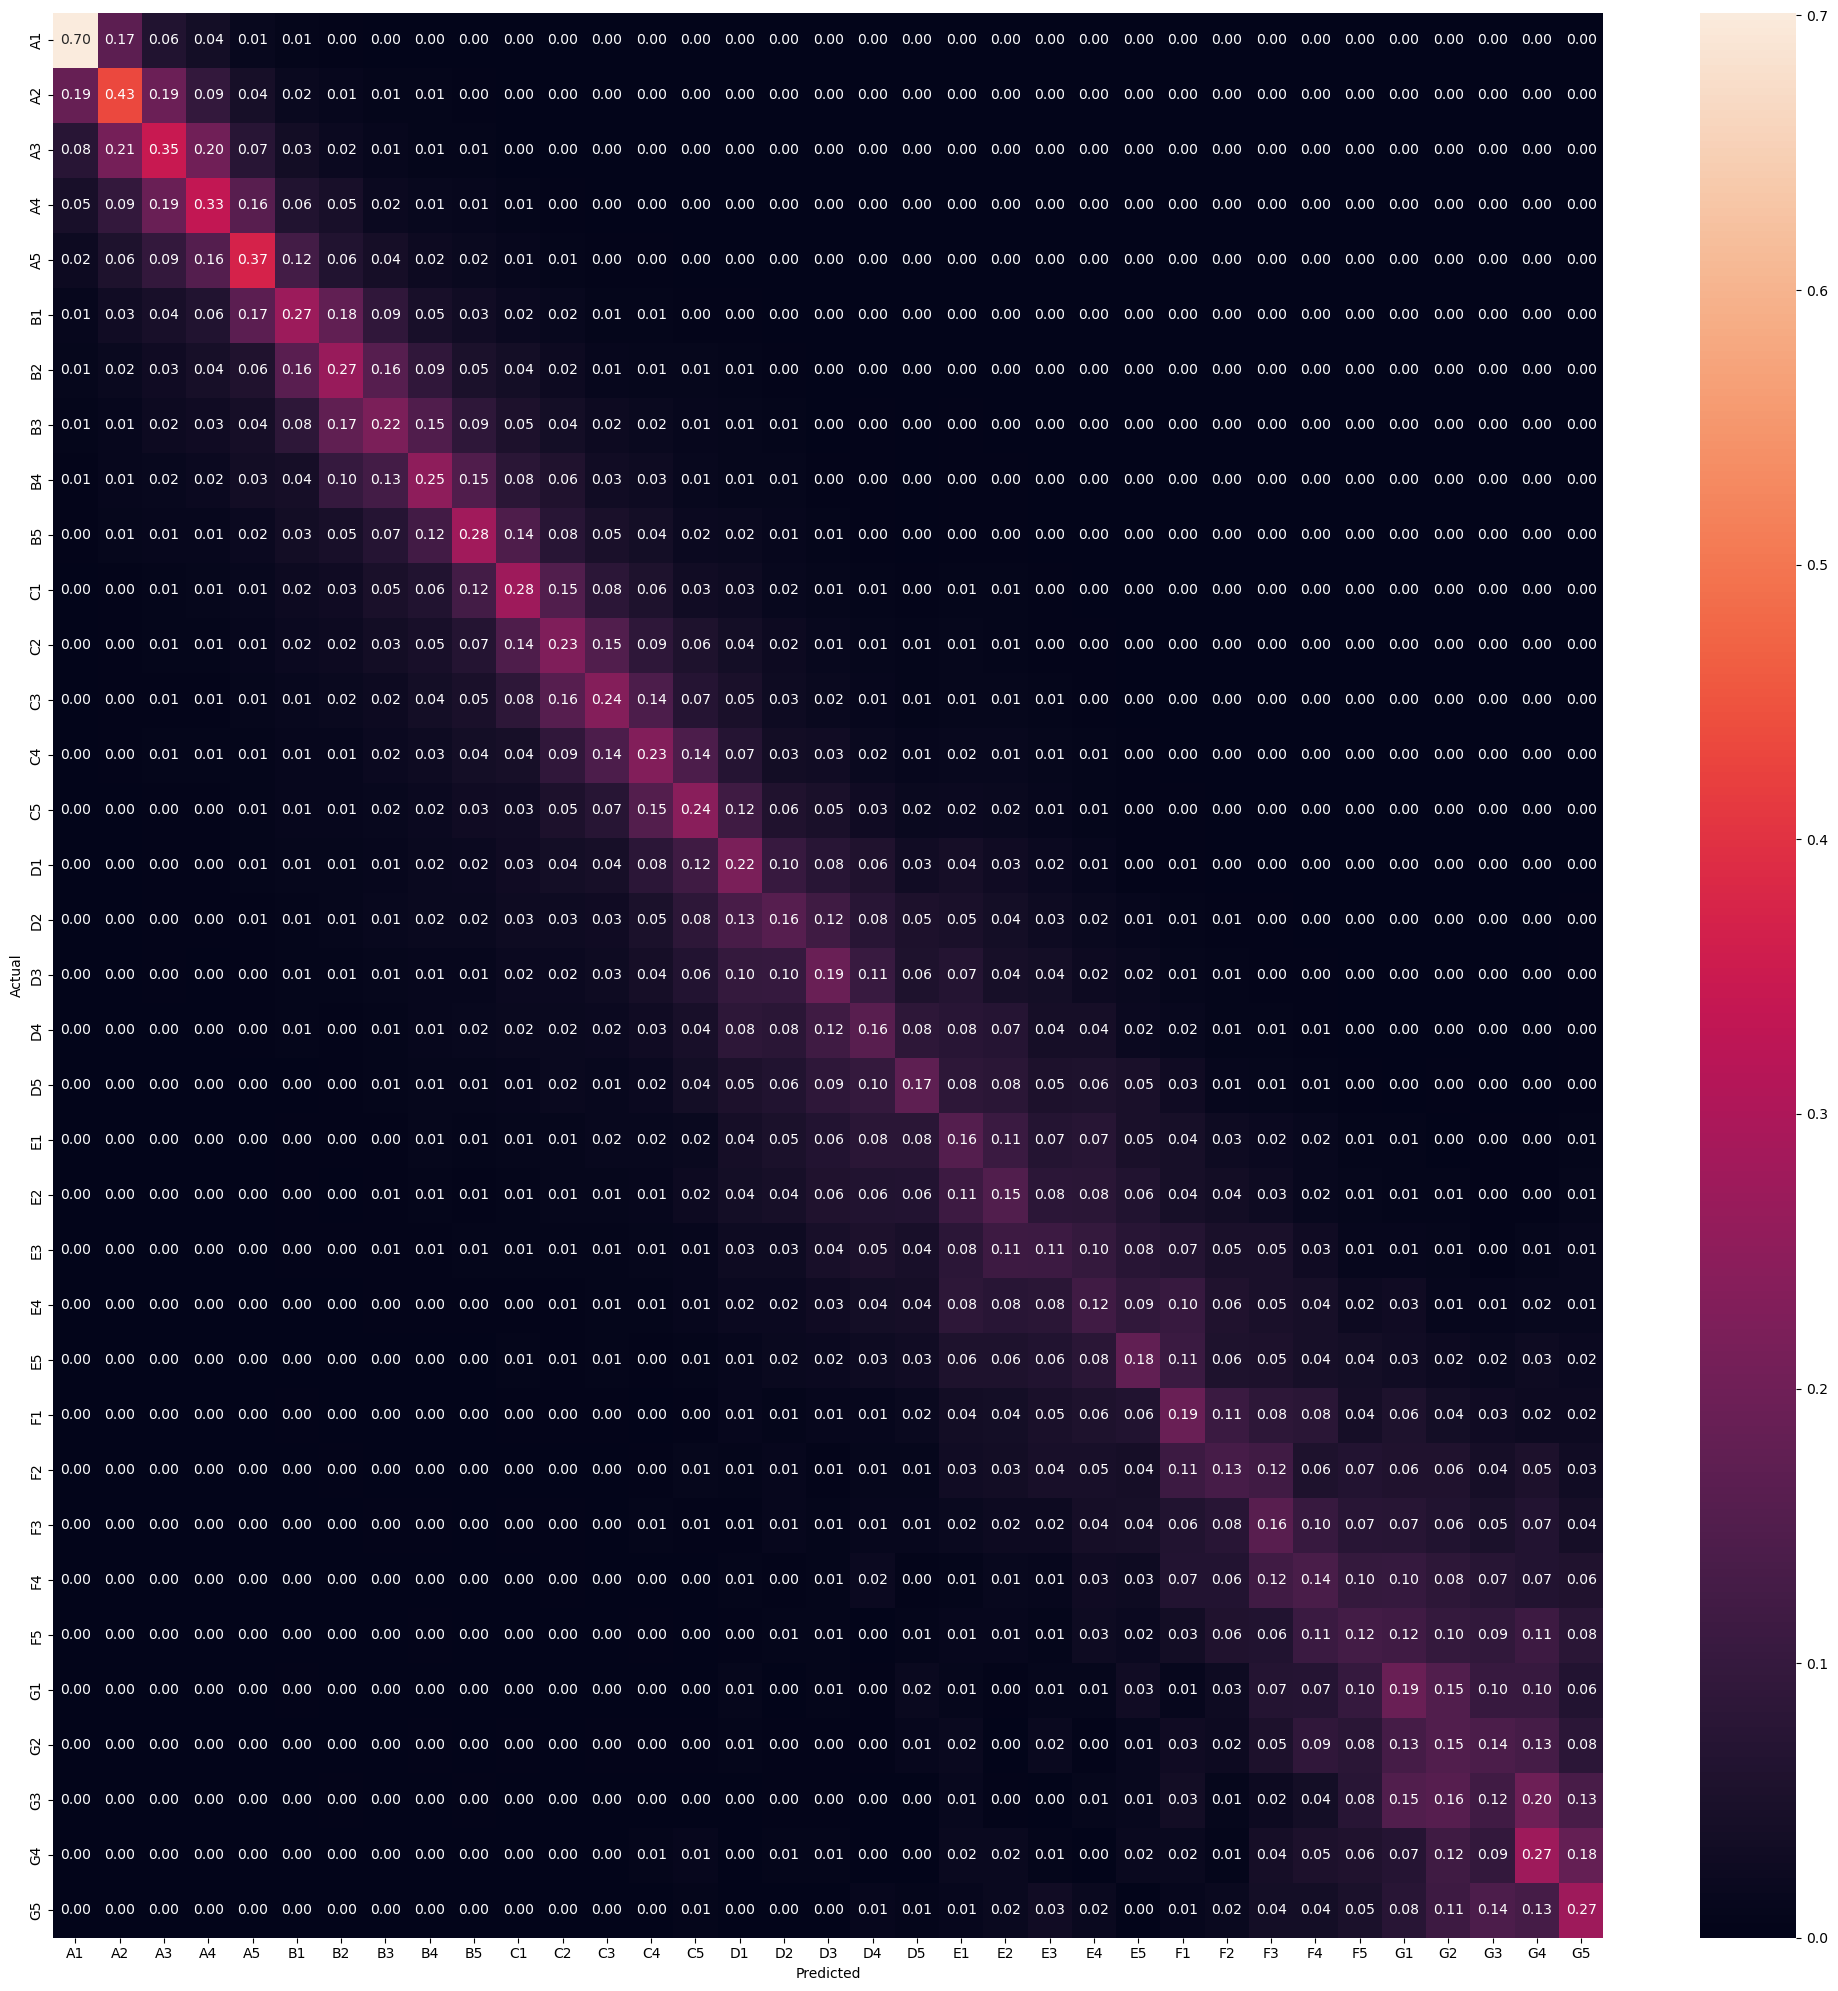

In [46]:
myFunc.big_confusion_matrix_normalized(
    y_val,
    y_pred_v,
    [
        "A1",
        "A2",
        "A3",
        "A4",
        "A5",
        "B1",
        "B2",
        "B3",
        "B4",
        "B5",
        "C1",
        "C2",
        "C3",
        "C4",
        "C5",
        "D1",
        "D2",
        "D3",
        "D4",
        "D5",
        "E1",
        "E2",
        "E3",
        "E4",
        "E5",
        "F1",
        "F2",
        "F3",
        "F4",
        "F5",
        "G1",
        "G2",
        "G3",
        "G4",
        "G5",
    ],
)


In [47]:
y_pred_test = model_tuned_xgb.predict(X_test)
print("\nClassification Report for XGB Classifier")
print(classification_report(y_test, y_pred_test))



Classification Report for XGB Classifier
              precision    recall  f1-score   support

           0       0.66      0.71      0.68      8679
           1       0.35      0.45      0.39      6956
           2       0.28      0.35      0.31      7318
           3       0.32      0.32      0.32      9588
           4       0.36      0.38      0.37     10762
           5       0.30      0.27      0.29     12534
           6       0.27      0.28      0.27     12662
           7       0.25      0.22      0.23     13151
           8       0.28      0.25      0.26     13980
           9       0.30      0.28      0.29     14029
          10       0.30      0.27      0.28     14590
          11       0.22      0.21      0.22     13111
          12       0.26      0.23      0.24     12919
          13       0.25      0.23      0.24     12711
          14       0.28      0.24      0.26     11672
          15       0.20      0.22      0.21      8178
          16       0.18      0.16      

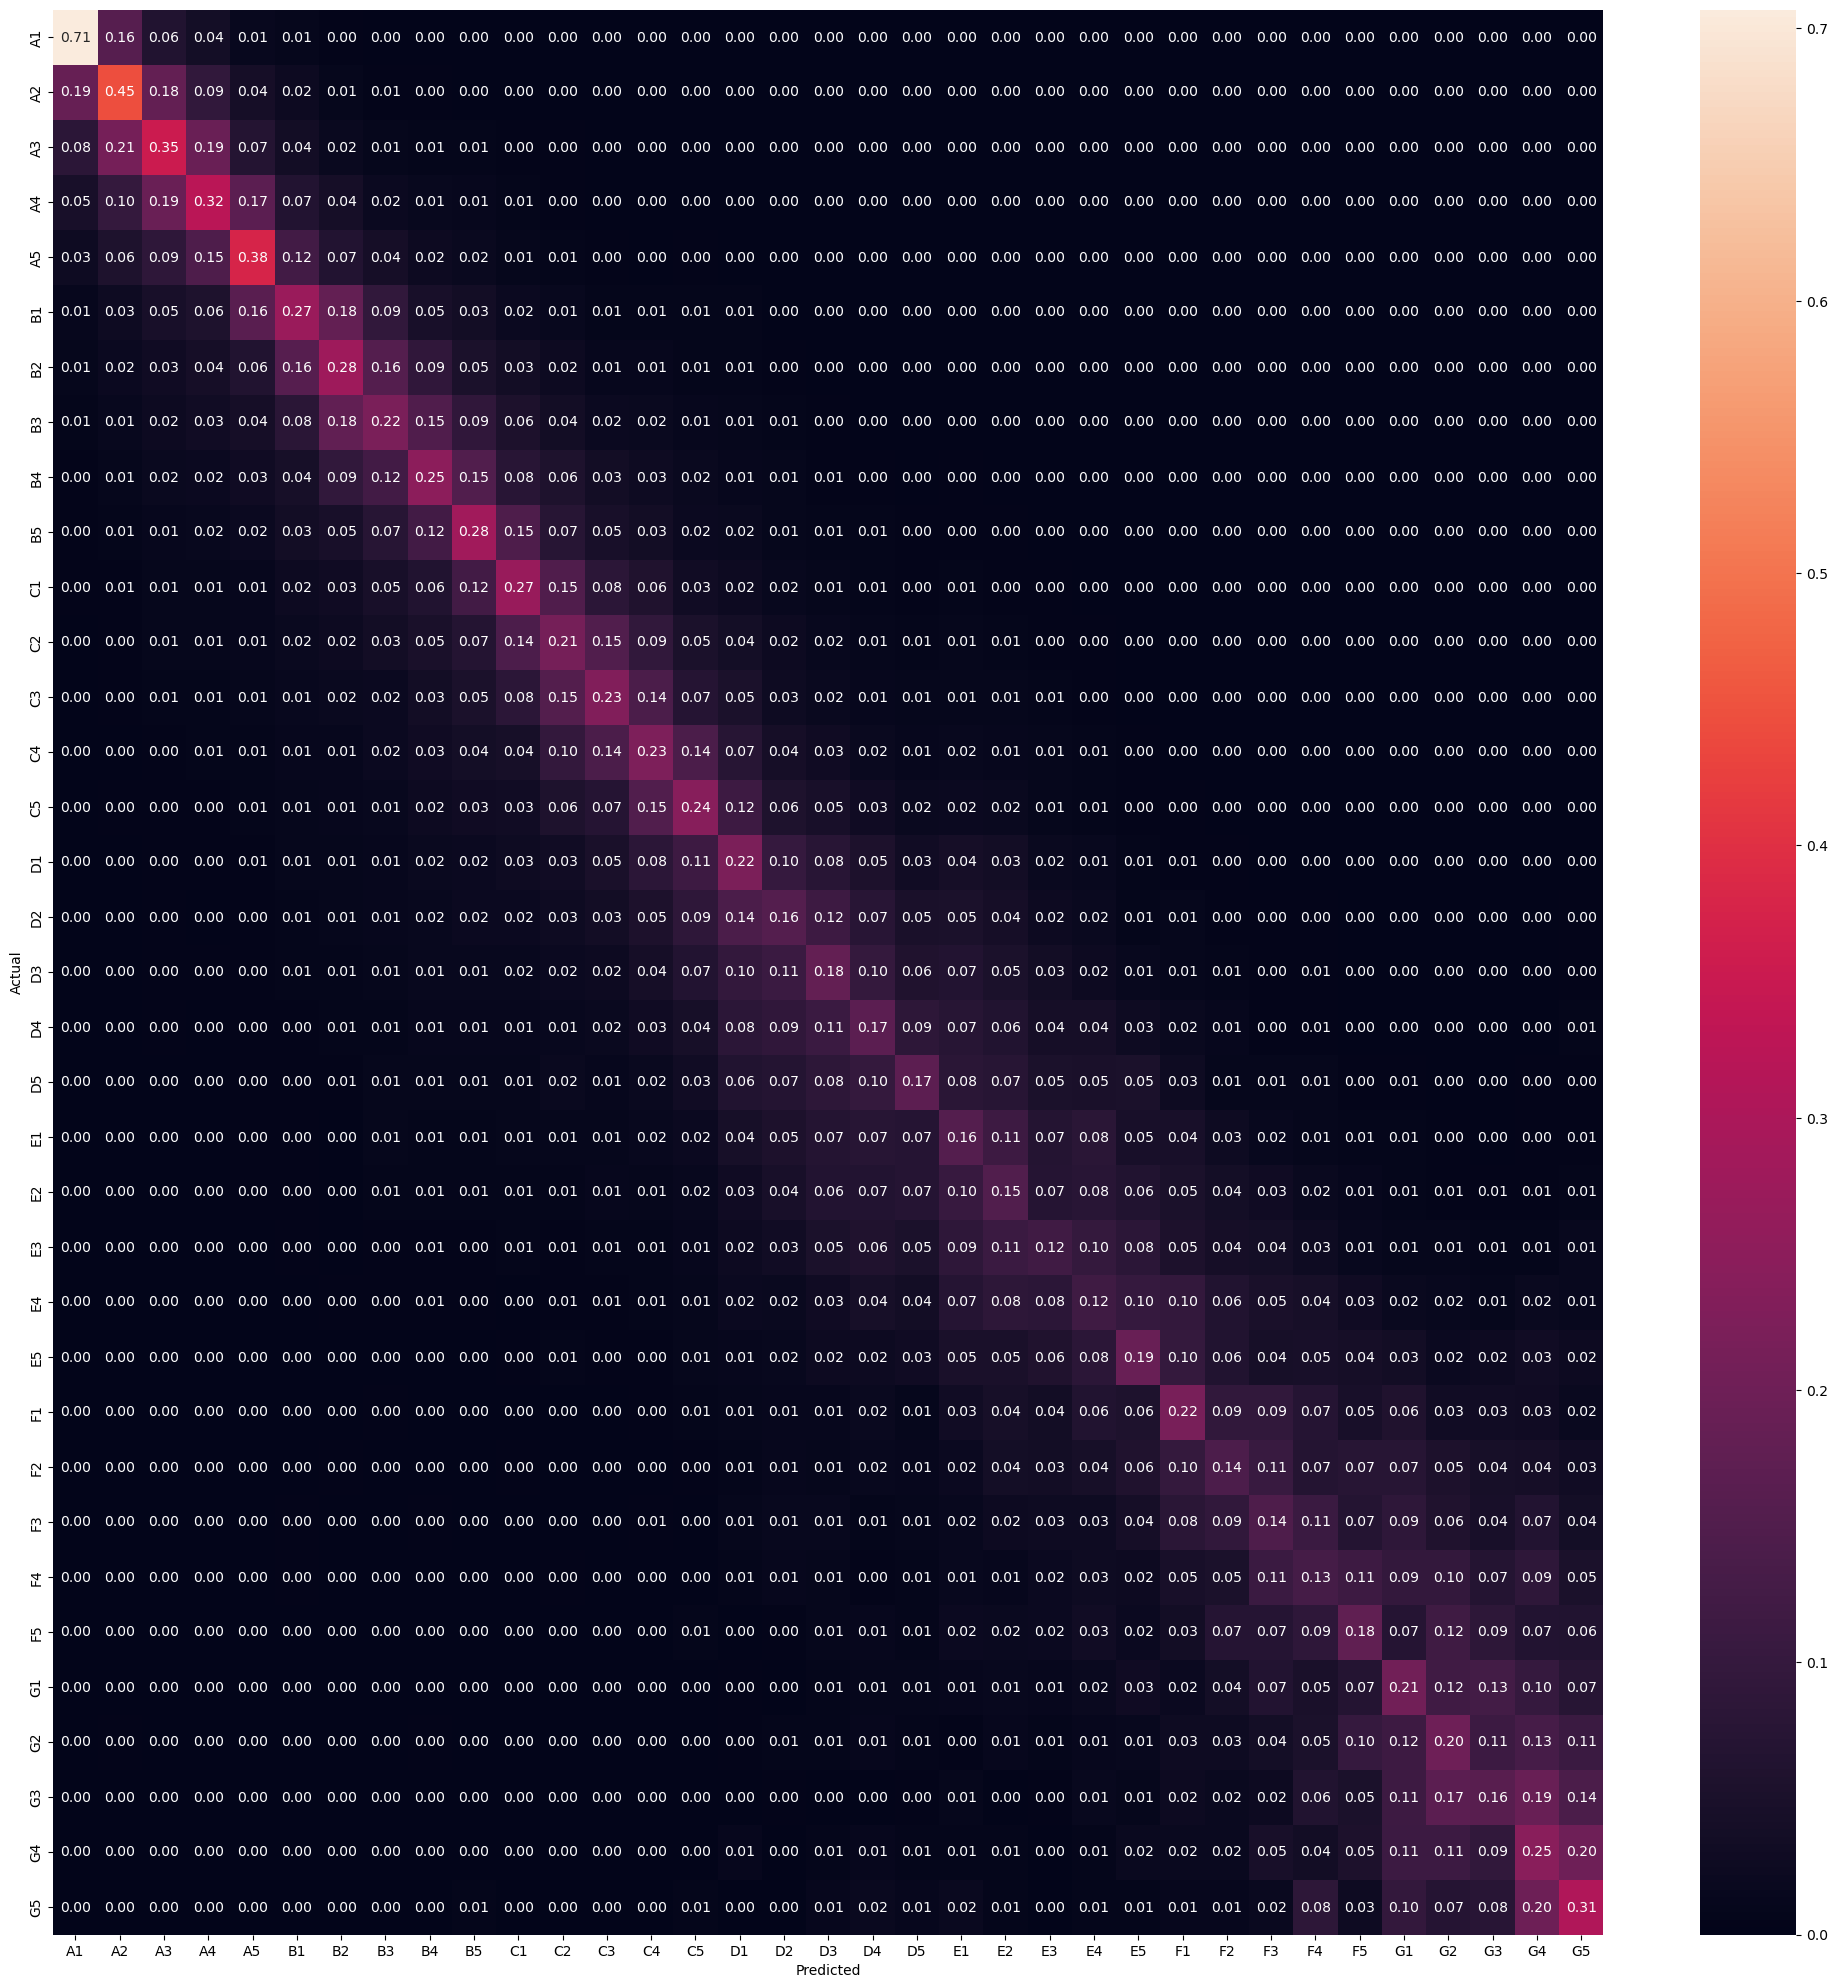

In [48]:
myFunc.big_confusion_matrix_normalized(
    y_test,
    y_pred_test,
    [
        "A1",
        "A2",
        "A3",
        "A4",
        "A5",
        "B1",
        "B2",
        "B3",
        "B4",
        "B5",
        "C1",
        "C2",
        "C3",
        "C4",
        "C5",
        "D1",
        "D2",
        "D3",
        "D4",
        "D5",
        "E1",
        "E2",
        "E3",
        "E4",
        "E5",
        "F1",
        "F2",
        "F3",
        "F4",
        "F5",
        "G1",
        "G2",
        "G3",
        "G4",
        "G5",
    ],
)


In [49]:
dump(pipeline_xgb, "sub_grade_classifier.joblib")


['sub_grade_classifier.joblib']

We successfully improved the F1 score from 0.18 to 0.21 by fine-tuning the hyperparameters for the XGBoost Classifier. This represents the best possible model achievable using this approach.